In [1]:
import cv2
from PIL import Image
import time
from tqdm import tqdm 

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.init
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import python.helper as helper
import myNN
import util


In [2]:
learning_rate = 0.001
training_epochs = 100
batch_size = 3

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
class RoadDataset(Dataset):
    def __init__(self, xRoot, yRoot="", train=True, transform=False):
        self.x_datas = []
        self.y_datas = []
        self.train = train
        self.transform = transform
        for files in os.listdir(xRoot):
            self.x_datas.append(xRoot + "/" + files)
        
        if self.train:
            for files in os.listdir(yRoot):
                self.y_datas.append(yRoot + "/" + files)

    def __len__(self):
        return len(self.x_datas)

    def __getitem__(self, idx):
        x =  Image.open(self.x_datas[idx]).convert("RGB")
        x = x.resize(myNN.INPUT_IMAGE_SHAPE)
        if self.transform:
            x = self.transform(x)
        
        x = np.array(x)
        if self.train:
            y, _ = helper.getGroundTruth(self.y_datas[idx])
            y = Image.fromarray(y)
            y = y.resize(myNN.INPUT_IMAGE_SHAPE)
            y = np.array(y)
            return x, y
        
        return x

roadTrainDataset = RoadDataset("./data_road/training/image_2", yRoot="./data_road/training/gt_image_2", transform=transforms.ColorJitter(brightness=1))
roadTestDataset = RoadDataset("./data_road/testing/image_2", train=False)

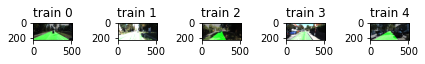

In [4]:
import random

fig, ax = plt.subplots(1, 5)


for i in range(5):
    randId = int(random.random() * len(roadTrainDataset))
    roadTrainData = roadTrainDataset[randId]

    img = helper.overlayImageWithConfidence(roadTrainData[0], roadTrainData[1])

    ax[i].imshow(img)
    ax[i].set_title("train {}".format(i))


plt.tight_layout()
plt.show()

In [5]:
roadTrain_loader = DataLoader(dataset=roadTrainDataset, batch_size=batch_size,shuffle=True)
roadTest_loader = DataLoader(dataset=roadTestDataset, batch_size=1,shuffle=True)

In [6]:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.manual_seed(777)

    if device == 'cuda':
        torch.cuda.manual_seed_all(777)

    model = myNN.myNN()
    model = torch.nn.DataParallel(model)
    model.to(device)


criterion = torch.nn.MSELoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [7]:
train_losses = []
for singleEpoch in range(1, training_epochs+1):
    startTime = time.time()
    train_loss = 0.0

    model.train()
    for data, ans in tqdm(roadTrain_loader, desc="Epoch: {}".format(singleEpoch)):
        data = data.permute(0, 3, 1, 2)
        
        # move tensor to gpu
        data = data.to(device, non_blocking=True).float()
        ans = ans.to(device, non_blocking=True).float()

        # cleaer the gradients all optimized variables
        optimizer.zero_grad()

        # forward process
        output = model(data)
        #output = output[None,...]
        # backpropagation
        loss = criterion(output, ans)
        
        loss.backward()
        optimizer.step()

        # update training loss
        train_loss += loss.item()

    # calculate-average-losses
    train_loss = train_loss/len(roadTrain_loader.sampler)
    train_losses.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f}\ttime: {:.3f}'.format(singleEpoch, train_loss, time.time() - startTime))
    
    

Epoch: 1:   0%|          | 0/65 [00:00<?, ?it/s]C:\Users\yunmi\anaconda3\envs\torch-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\yunmi\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([3, 224, 512])) that is different to the input size (torch.Size([3, 1, 224, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch: 1:  98%|█████████▊| 64/65 [00:14<00:00,  4.46it/s]C:\Users\yunmi\anaconda3\envs\torch-env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarni

Epoch: 1 	Training Loss: 14.878218	time: 14.675


Epoch: 2: 100%|██████████| 65/65 [00:14<00:00,  4.33it/s]


Epoch: 2 	Training Loss: 0.183864	time: 15.001


Epoch: 3: 100%|██████████| 65/65 [00:13<00:00,  4.66it/s]


Epoch: 3 	Training Loss: 0.049149	time: 13.945


Epoch: 4: 100%|██████████| 65/65 [00:13<00:00,  4.64it/s]


Epoch: 4 	Training Loss: 0.047291	time: 13.997


Epoch: 5: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 5 	Training Loss: 0.046209	time: 14.059


Epoch: 6: 100%|██████████| 65/65 [00:13<00:00,  4.64it/s]


Epoch: 6 	Training Loss: 0.046042	time: 14.000


Epoch: 7: 100%|██████████| 65/65 [00:14<00:00,  4.64it/s]


Epoch: 7 	Training Loss: 0.046496	time: 14.018


Epoch: 8: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 8 	Training Loss: 0.045427	time: 14.039


Epoch: 9: 100%|██████████| 65/65 [00:14<00:00,  4.64it/s]


Epoch: 9 	Training Loss: 0.046722	time: 14.012


Epoch: 10: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 10 	Training Loss: 0.046055	time: 14.049


Epoch: 11: 100%|██████████| 65/65 [00:14<00:00,  4.64it/s]


Epoch: 11 	Training Loss: 0.045766	time: 14.022


Epoch: 12: 100%|██████████| 65/65 [00:14<00:00,  4.64it/s]


Epoch: 12 	Training Loss: 0.045575	time: 14.014


Epoch: 13: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 13 	Training Loss: 0.045144	time: 14.026


Epoch: 14: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 14 	Training Loss: 0.044148	time: 14.073


Epoch: 15: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 15 	Training Loss: 0.045065	time: 14.040


Epoch: 16: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 16 	Training Loss: 0.045541	time: 14.067


Epoch: 17: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 17 	Training Loss: 0.046130	time: 14.036


Epoch: 18: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 18 	Training Loss: 0.044444	time: 14.067


Epoch: 19: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 19 	Training Loss: 0.043568	time: 14.115


Epoch: 20: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 20 	Training Loss: 0.044115	time: 14.077


Epoch: 21: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 21 	Training Loss: 0.043196	time: 14.128


Epoch: 22: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 22 	Training Loss: 0.045113	time: 14.058


Epoch: 23: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 23 	Training Loss: 0.042874	time: 14.055


Epoch: 24: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 24 	Training Loss: 0.042192	time: 14.035


Epoch: 25: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 25 	Training Loss: 0.045679	time: 14.028


Epoch: 26: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 26 	Training Loss: 0.043543	time: 14.073


Epoch: 27: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 27 	Training Loss: 0.043540	time: 14.050


Epoch: 28: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 28 	Training Loss: 0.043235	time: 14.032


Epoch: 29: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 29 	Training Loss: 0.042666	time: 14.072


Epoch: 30: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 30 	Training Loss: 0.047845	time: 14.071


Epoch: 31: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 31 	Training Loss: 0.042857	time: 14.068


Epoch: 32: 100%|██████████| 65/65 [00:14<00:00,  4.64it/s]


Epoch: 32 	Training Loss: 0.044281	time: 14.019


Epoch: 33: 100%|██████████| 65/65 [00:14<00:00,  4.64it/s]


Epoch: 33 	Training Loss: 0.043854	time: 14.012


Epoch: 34: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 34 	Training Loss: 0.043898	time: 14.080


Epoch: 35: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 35 	Training Loss: 0.042147	time: 14.057


Epoch: 36: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 36 	Training Loss: 0.041563	time: 14.067


Epoch: 37: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 37 	Training Loss: 0.043329	time: 14.059


Epoch: 38: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 38 	Training Loss: 0.043360	time: 14.088


Epoch: 39: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 39 	Training Loss: 0.041796	time: 14.077


Epoch: 40: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 40 	Training Loss: 0.043976	time: 14.125


Epoch: 41: 100%|██████████| 65/65 [00:14<00:00,  4.54it/s]


Epoch: 41 	Training Loss: 0.044886	time: 14.304


Epoch: 42: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


Epoch: 42 	Training Loss: 0.045649	time: 14.296


Epoch: 43: 100%|██████████| 65/65 [00:14<00:00,  4.54it/s]


Epoch: 43 	Training Loss: 0.041731	time: 14.331


Epoch: 44: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


Epoch: 44 	Training Loss: 0.043414	time: 14.294


Epoch: 45: 100%|██████████| 65/65 [00:14<00:00,  4.54it/s]


Epoch: 45 	Training Loss: 0.041520	time: 14.317


Epoch: 46: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


Epoch: 46 	Training Loss: 0.044990	time: 14.297


Epoch: 47: 100%|██████████| 65/65 [00:14<00:00,  4.54it/s]


Epoch: 47 	Training Loss: 0.043224	time: 14.316


Epoch: 48: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


Epoch: 48 	Training Loss: 0.042211	time: 14.294


Epoch: 49: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


Epoch: 49 	Training Loss: 0.042130	time: 14.280


Epoch: 50: 100%|██████████| 65/65 [00:14<00:00,  4.54it/s]


Epoch: 50 	Training Loss: 0.041781	time: 14.305


Epoch: 51: 100%|██████████| 65/65 [00:14<00:00,  4.55it/s]


Epoch: 51 	Training Loss: 0.042578	time: 14.299


Epoch: 52: 100%|██████████| 65/65 [00:14<00:00,  4.54it/s]


Epoch: 52 	Training Loss: 0.041412	time: 14.324


Epoch: 53: 100%|██████████| 65/65 [00:14<00:00,  4.57it/s]


Epoch: 53 	Training Loss: 0.040511	time: 14.216


Epoch: 54: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 54 	Training Loss: 0.041231	time: 14.064


Epoch: 55: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 55 	Training Loss: 0.040127	time: 14.029


Epoch: 56: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 56 	Training Loss: 0.043469	time: 14.083


Epoch: 57: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 57 	Training Loss: 0.040721	time: 14.077


Epoch: 58: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 58 	Training Loss: 0.041578	time: 14.077


Epoch: 59: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 59 	Training Loss: 0.042889	time: 14.105


Epoch: 60: 100%|██████████| 65/65 [00:14<00:00,  4.59it/s]


Epoch: 60 	Training Loss: 0.042218	time: 14.176


Epoch: 61: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 61 	Training Loss: 0.041668	time: 14.097


Epoch: 62: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 62 	Training Loss: 0.041209	time: 14.103


Epoch: 63: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 63 	Training Loss: 0.039841	time: 14.046


Epoch: 64: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 64 	Training Loss: 0.040499	time: 14.080


Epoch: 65: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 65 	Training Loss: 0.042044	time: 14.056


Epoch: 66: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 66 	Training Loss: 0.041676	time: 14.114


Epoch: 67: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 67 	Training Loss: 0.039637	time: 14.033


Epoch: 68: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 68 	Training Loss: 0.045014	time: 14.107


Epoch: 69: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 69 	Training Loss: 0.041643	time: 14.090


Epoch: 70: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 70 	Training Loss: 0.040062	time: 14.125


Epoch: 71: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 71 	Training Loss: 0.039321	time: 14.128


Epoch: 72: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 72 	Training Loss: 0.039027	time: 14.099


Epoch: 73: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 73 	Training Loss: 0.037969	time: 14.077


Epoch: 74: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 74 	Training Loss: 0.037471	time: 14.119


Epoch: 75: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 75 	Training Loss: 0.037285	time: 14.086


Epoch: 76: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 76 	Training Loss: 0.037455	time: 14.098


Epoch: 77: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 77 	Training Loss: 0.038145	time: 14.083


Epoch: 78: 100%|██████████| 65/65 [00:14<00:00,  4.64it/s]


Epoch: 78 	Training Loss: 0.038058	time: 14.024


Epoch: 79: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 79 	Training Loss: 0.036284	time: 14.055


Epoch: 80: 100%|██████████| 65/65 [00:14<00:00,  4.59it/s]


Epoch: 80 	Training Loss: 0.036557	time: 14.155


Epoch: 81: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 81 	Training Loss: 0.036050	time: 14.139


Epoch: 82: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 82 	Training Loss: 0.035858	time: 14.083


Epoch: 83: 100%|██████████| 65/65 [00:14<00:00,  4.58it/s]


Epoch: 83 	Training Loss: 0.035589	time: 14.206


Epoch: 84: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 84 	Training Loss: 0.033774	time: 14.079


Epoch: 85: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 85 	Training Loss: 0.035932	time: 14.066


Epoch: 86: 100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch: 86 	Training Loss: 0.035340	time: 14.043


Epoch: 87: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 87 	Training Loss: 0.033547	time: 14.119


Epoch: 88: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 88 	Training Loss: 0.037116	time: 14.061


Epoch: 89: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 89 	Training Loss: 0.035989	time: 14.109


Epoch: 90: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 90 	Training Loss: 0.036805	time: 14.072


Epoch: 91: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 91 	Training Loss: 0.034286	time: 14.132


Epoch: 92: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 92 	Training Loss: 0.033334	time: 14.138


Epoch: 93: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 93 	Training Loss: 0.032637	time: 14.069


Epoch: 94: 100%|██████████| 65/65 [00:14<00:00,  4.62it/s]


Epoch: 94 	Training Loss: 0.031525	time: 14.065


Epoch: 95: 100%|██████████| 65/65 [00:14<00:00,  4.59it/s]


Epoch: 95 	Training Loss: 0.031790	time: 14.151


Epoch: 96: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]


Epoch: 96 	Training Loss: 0.032008	time: 14.102


Epoch: 97: 100%|██████████| 65/65 [00:14<00:00,  4.59it/s]


Epoch: 97 	Training Loss: 0.039575	time: 14.173


Epoch: 98: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 98 	Training Loss: 0.032918	time: 14.137


Epoch: 99: 100%|██████████| 65/65 [00:14<00:00,  4.60it/s]


Epoch: 99 	Training Loss: 0.032463	time: 14.126


Epoch: 100: 100%|██████████| 65/65 [00:14<00:00,  4.61it/s]

Epoch: 100 	Training Loss: 0.031550	time: 14.116


In [9]:
torch.save(model.state_dict(), "model_road_detect.ckpt")